# Exploring TensorFlow Probability STS Forecasting

In this notebook we explore the [Structural Time Series (STS) Module](https://www.tensorflow.org/probability/api_docs/python/tfp/sts) of [TensorFlow Probability](https://www.tensorflow.org/probability/). We follow closely the [use cases](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083) presented in their [Medium blog](https://medium.com/tensorflow). As described there: *An STS model expresses an observed time series as the sum of simpler components*: 

$$
f(t) = \sum_{k=1}^{N}f_{k}(t) + \varepsilon, \quad \text{where}\quad \varepsilon \sim N(0, \sigma^2).
$$

Each summand $f_{k}(t)$ has a particular structure, e.g. specific seasonality, trend, autoregressive terms, etc.  

In this notebook we generate a time series sample and then present some techniques to recover its component structure. This is indeed a crucial step since in real applications we are not given the components separately. We then show how to fit and generate predictions using [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods). Finally we run some diagnostics of the errors on the test set. 

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.1.0
0.8.0-rc0


## Generate Data

We generate are going to consider daily data on the range `2017-01-01` to `2020-12-31`.

In [3]:
# Create dataframe with a date range (4 years).
date_range = pd.date_range(start='2017-01-01', end='2020-12-31', freq='D')
# Create data frame.
df = pd.DataFrame(data={'date': date_range})
# Extract number of points.
n = df.shape[0]

We begin by generating Gaussian noise. 

In [4]:
# Set seed.
np.random.seed(seed=42)

df['y'] = np.random.normal(loc=0.0, scale=0.5, size=n)

Next we define an external regressor `x`.

In [5]:
# External regressor:
df['x'] = np.random.uniform(low=0.0, high=1.0, size=n)
df['x'] = df['x'].apply(lambda x: x if abs(x) > 0.95 else 0.0)

df['y'] = df['y'] + 6*df['x']

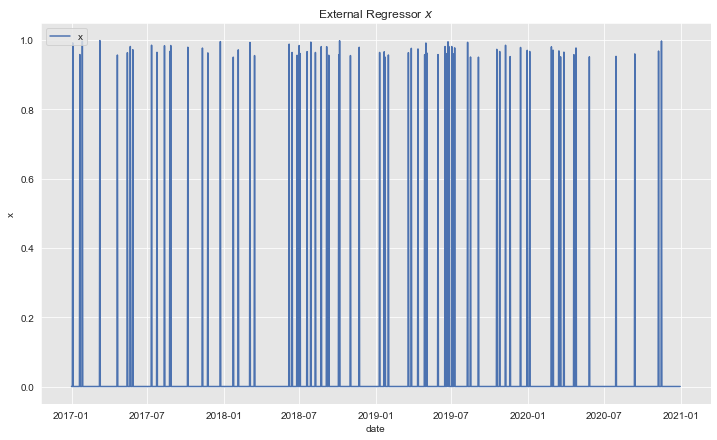

In [6]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, ax = plt.subplots()
sns.lineplot(x='date', y='x', label='x', data=df, ax=ax)
ax.legend(loc='upper left')
ax.set(title=r'External Regressor $x$');

Now, lewt us add a non-linear trend component of the form $t\longmapsto t^{1/3}$.

In [7]:
df['y'] = df['y'] + np.power(df.index.values, 1/3)

Finally, we add some seasonal variables, which we encode as cyclic variables using $\sin(z)$ and $\cos(z)$ functions.

In [8]:
# Seasonal features:
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['daysinmonth'] = df['date'].dt.daysinmonth


df['y'] = df['y'] \
    + 2*np.cos(2*np.pi*df['month']/12) + 0.5*np.sin(2*np.pi*df['month']/12)\
    + 1.5*np.cos(2*np.pi*df['day_of_week']/7) \
    + 2*np.sin(2*np.pi*df['day_of_month']/ df['daysinmonth'])

df['y'] = df['y'].fillna(method='backfill').astype(np.float32)

df.head(10)

,date,y,x,day_of_month,month,day_of_week,daysinmonth
0,2017-01-01,3.568240,0.00000,1,1,6,31
1,2017-01-02,5.201631,0.00000,2,1,0,31
2,2017-01-03,5.643587,0.00000,3,1,1,31
3,2017-01-04,11.252480,0.99181,4,1,2,31
4,2017-01-05,3.798210,0.00000,5,1,3,31
5,2017-01-06,4.099009,0.00000,6,1,4,31
6,2017-01-07,6.231933,0.00000,7,1,5,31
7,2017-01-08,7.211367,0.00000,8,1,6,31
8,2017-01-09,7.183468,0.00000,9,1,0,31
9,2017-01-10,7.064259,0.00000,10,1,1,31


Let us plot the generated data:

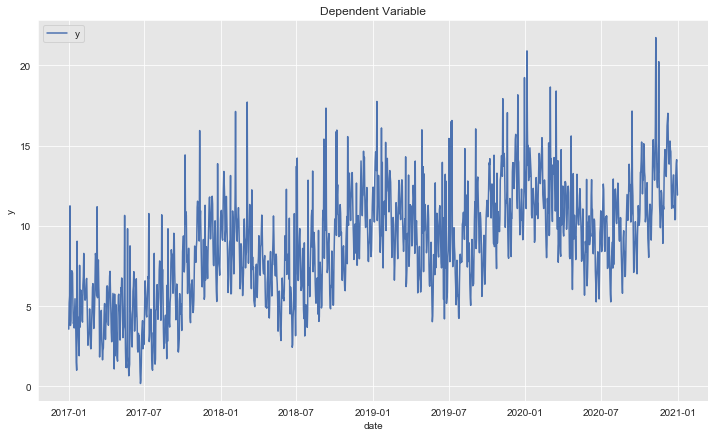

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='y', data=df, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dependent Variable');

## Train - Test Split

We assume we have data until `2020-06-30` and we will predict six months ahead. We assume we have acces to the `x` variable in advance (e.g. media spend plan). 

In [10]:
threshold_date = pd.to_datetime('2020-07-01')
mask = df['date'] < threshold_date

df_train = df[mask]
df_test = df[~ mask]

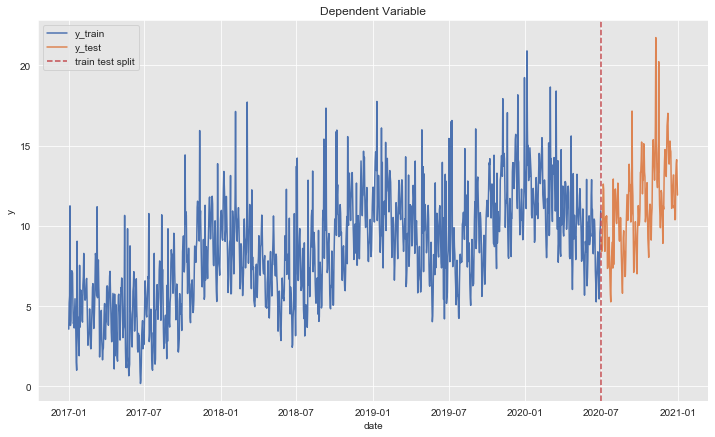

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='date', y='y', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable');

## Time Series Exploratory Analysis

We are going to assume we do not know how the data was generated. We present a sample of techniques to extract the seasonality and estimate the effect of the `x` variable on `y`. There is no unique way to do this and we focus on using the intuition and common sense to extract the relevant features. Time series forecasting can be a very challenging problem. Spending time on exploring the data is always a good investment in order to generate meaningful models. 

**Warning:** We just use the training data in this step so that we do not leak information from the test set. 

### Smoothing

We begin the analysis by studying and visualize various level of smoothness using a [`gaussian_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html). You can think of it as a weighted centered moving average based on a normal distribution. In particular, the level of smoothness is controlled by the parameter `sigma` which represents the standard deviation.

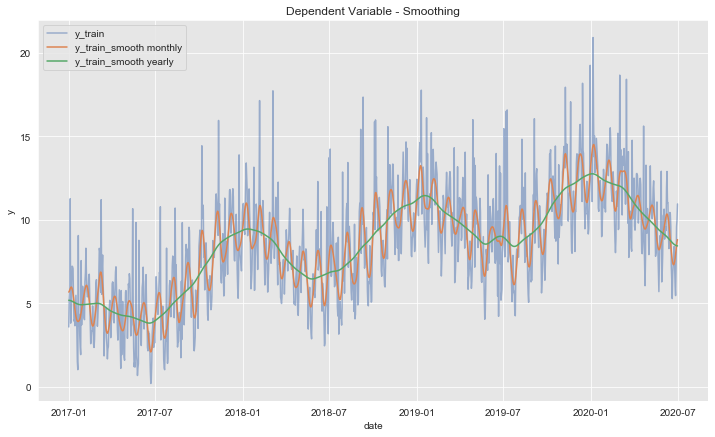

In [12]:
from scipy.ndimage import gaussian_filter

df_smooth = df_train \
    .assign(y_smooth_1 = lambda x: gaussian_filter(input=x['y'], sigma=3.5)) \
    .assign(y_smooth_2 = lambda x: gaussian_filter(input=x['y'], sigma=15)) \

fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='y_train', data=df_smooth, alpha=0.5, ax=ax)
sns.lineplot(x='date', y='y_smooth_1', label='y_train_smooth monthly', data=df_smooth, ax=ax)
sns.lineplot(x='date', y='y_smooth_2', label='y_train_smooth yearly', data=df_smooth, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dependent Variable - Smoothing', ylabel='y');

From this plot we see two clear seasonalities: yearly and monthly. The variable `y_train_smooth yearly` also includes a positive trend component, which does not look linear. 

To understand how to model the monthly seasonality we plot the mean of `y` over the day of the month. 

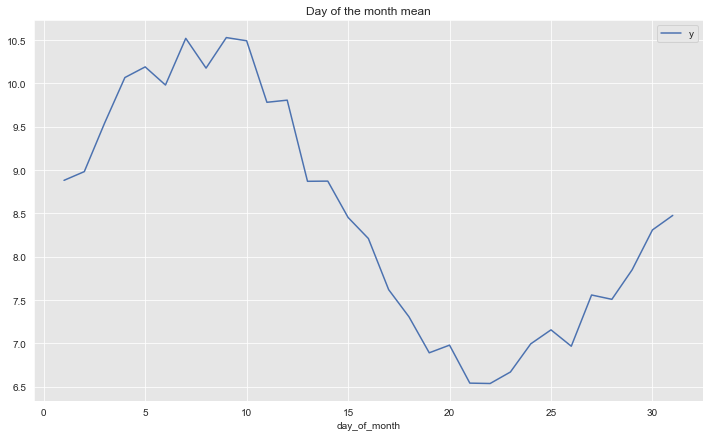

In [13]:
fig, ax = plt.subplots()
df_train.groupby('day_of_month').agg({'y': np.mean}).plot(ax=ax)
ax.set(title='Day of the month mean');

This shows a good first approximation is to model this component via a cyclic variable of the form $z\longmapsto \sin(z)$.

### Remove yearly and monthly seasonality

Let us remove these two seasonal components:

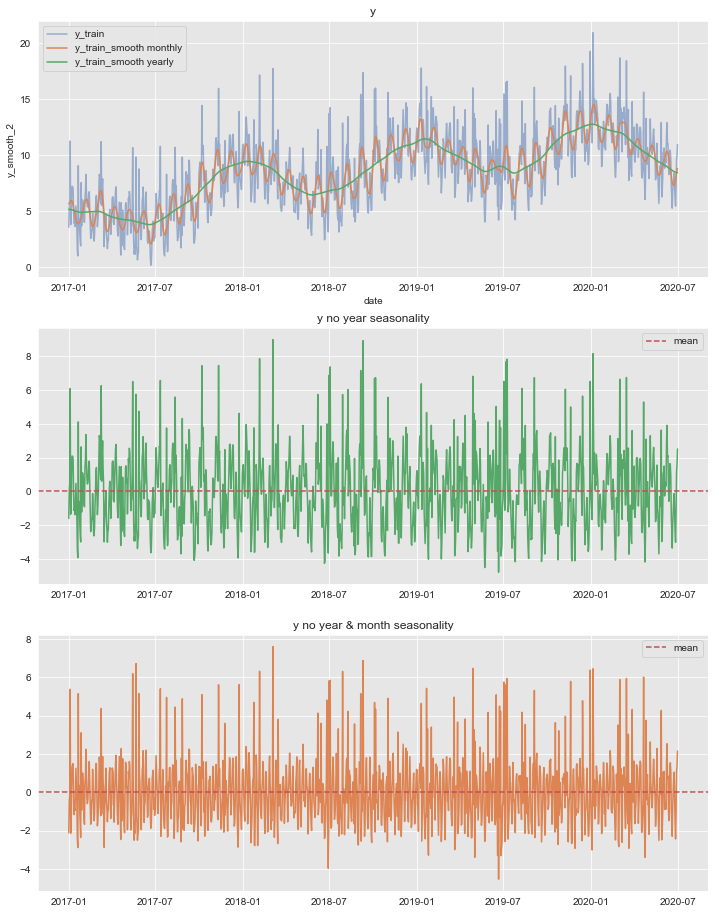

In [14]:
# Remove yearly seasonality.
y_no_year_season = df_smooth['y'] - df_smooth['y_smooth_2']
# Remove monthly seasonality.
y_no_year_month_season = y_no_year_season \
    - gaussian_filter(input=y_no_year_season, sigma=3.5)

# Plot components.
fig, ax = plt.subplots(3, 1, figsize=(12, 16))
sns.lineplot(x='date', y='y', label='y_train', data=df_smooth, alpha=0.5, ax=ax[0])
sns.lineplot(x='date', y='y_smooth_1', label='y_train_smooth monthly', data=df_smooth, ax=ax[0])
sns.lineplot(x='date', y='y_smooth_2', label='y_train_smooth yearly', data=df_smooth, ax=ax[0])
ax[0].set(title='y')

ax[1].plot(df_smooth['date'], y_no_year_season, c=sns_c[2])
ax[1].axhline(y_no_year_season.mean(), color=sns_c[3], linestyle='--', label='mean')
ax[1].legend()
ax[1].set(title='y no year seasonality')

ax[2].plot(df_smooth['date'], y_no_year_month_season, c=sns_c[1])
ax[2].axhline(y_no_year_month_season.mean(), color=sns_c[3], linestyle='--', label='mean')
ax[2].legend()
ax[2].set(title='y no year & month seasonality');

### AC and PAC

Let us now compute the auto correlation and partial-autocorrelation of the remainder component.

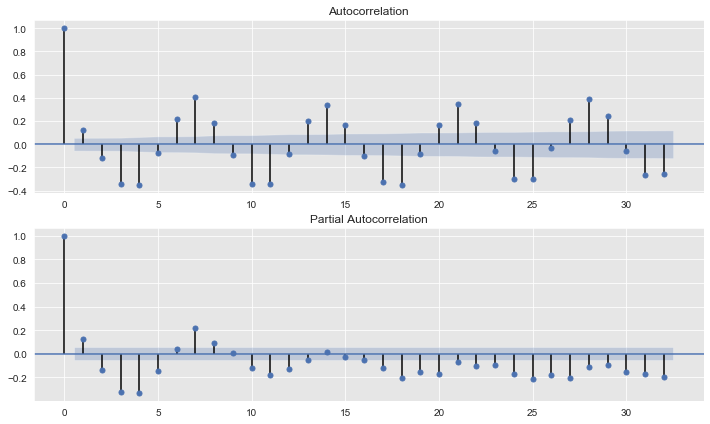

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1)
plot_acf(x=y_no_year_month_season, ax=ax[0])
plot_pacf(x=y_no_year_month_season, ax=ax[1]);

From the autocorrelation plot we observe a clear seasonality component at lag 7. Moreover, looking into the shape of the plot we can also see that the encoding is cyclical.

### Correlations

We want to see wether there is a linear effect of `x` on `y`. A first good indiication can be obtained by looking into correlations. Naively, one would  simply compute:

In [16]:
np.corrcoef(df_train['y'], df_train['x'])[0, 1]

0.3773272976778308

However, this correlation does not reflect the potential relation of `x` on `y` since we have a clear positive trend and seasonality components. A more meaningful indication is the correlation:

In [17]:
np.corrcoef(y_no_year_month_season, df_train['x'])[0, 1]

0.6714258581031259

Note that we still have not removed the 7-day (weekly) seasonality. This of course has an effect on this correlation. To see this let us consider the scatter plot:

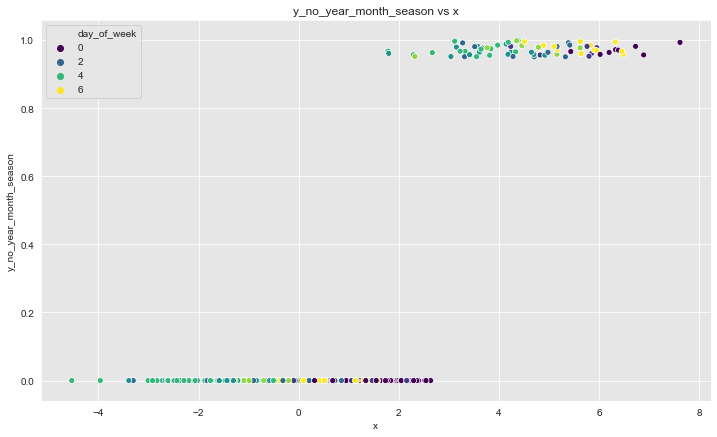

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=y_no_year_month_season, 
    y=df_train['x'], 
    hue=df['day_of_week'],
    palette='viridis',
    ax=ax, 
)

ax.set(
    title='y_no_year_month_season vs x', 
    xlabel='x', 
    ylabel='y_no_year_month_season'
);

We indeed see we have clear clusters on each level of `x` corrspondinig to each day of the week. 

One way of removing this seasonality is via a linear regression model. We use a one-hot encoding for the day of the week variable.

**Remark:** As we have seen before a cyclical encoding might be a better choise. Nevertheless, given how the data was generated, we want to test the one-hot encoding approach. 

In [19]:
# Prepare model data frame.
dow_df = df_train[['day_of_week']].copy()
dow_df['y_no_year_month_season'] = y_no_year_month_season
# One-hot encoding of the day of the week.
dow_dummies = pd.get_dummies(dow_df['day_of_week'], drop_first=True)
dow_dummies.columns = ['d' + str(i) for i in dow_dummies.columns]
dow_df = pd.concat([dow_df, dow_dummies], axis=1)
dow_df.head()

,day_of_week,y_no_year_month_season,d1,d2,d3,d4,d5,d6
0,6,-2.105084,0,0,0,0,0,1
1,0,-0.513847,0,0,0,0,0,0
2,1,-0.143844,1,0,0,0,0,0
3,2,5.383627,0,1,0,0,0,0
4,3,-2.138967,0,0,1,0,0,0


Next, we fit the linear model.

In [20]:
import statsmodels.formula.api as smf

dow_mod = smf.ols(
    formula='y_no_year_month_season ~  d1 + d2 + d3 + d4 + d5 + d6', 
    data=dow_df
)

dow_res = dow_mod.fit()

print(dow_res.summary())

                              OLS Regression Results                              
Dep. Variable:     y_no_year_month_season   R-squared:                       0.350
Model:                                OLS   Adj. R-squared:                  0.347
Method:                     Least Squares   F-statistic:                     114.2
Date:                    Tue, 11 Feb 2020   Prob (F-statistic):          2.64e-115
Time:                            11:32:43   Log-Likelihood:                -2214.7
No. Observations:                    1277   AIC:                             4443.
Df Residuals:                        1270   BIC:                             4479.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

We now compute the correlation of the regressor `x` with the model residuals:

In [21]:
np.corrcoef(dow_res.resid, df_train['x'])[0, 1]

0.8612502137457188

The correlation increased significantly. 

### Regressor Effect

A common question in time series analysis is to estimate the effect (ROI) of a specific external regressor (e.g. what is the ROI of media spend on sales?) For this specific case, given the correlation above, we can estimate this for `x` running a linear model on the residuals of the `dow_model`.

In [22]:
x_df = df_train[['x']].copy()
x_df['dow_model_resid'] = dow_res.resid

x_mod = smf.ols(formula='dow_model_resid ~ x', data=x_df)

x_res = x_mod.fit()

print(x_res.summary())

                            OLS Regression Results                            
Dep. Variable:        dow_model_resid   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     3662.
Date:                Tue, 11 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:32:44   Log-Likelihood:                -1350.3
No. Observations:                1277   AIC:                             2705.
Df Residuals:                    1275   BIC:                             2715.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2907      0.020    -14.467      0.0

The estimates effect is then:

In [23]:
x_res.params['x']

5.236046936179519

Recall that the *true* effect is 5.0.

### Periodogram

There is another way to extract seasonality patterns: using a [periodogram](https://en.wikipedia.org/wiki/Periodogram) to estimate the [spectral densty](https://en.wikipedia.org/wiki/Spectral_density) of a signal.

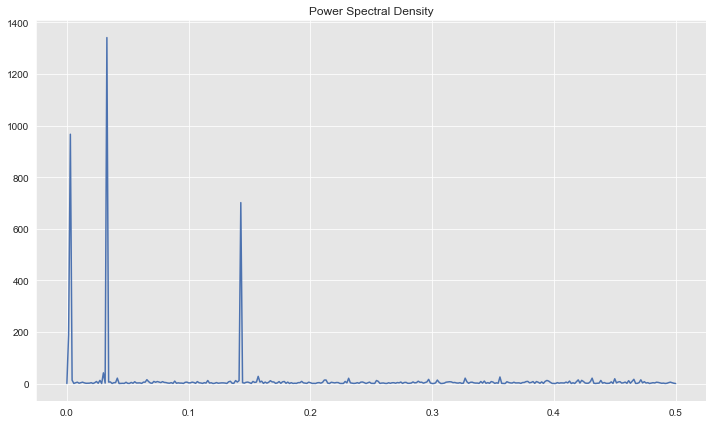

In [24]:
from scipy import signal

f, Pxx_den = signal.periodogram(
    x=df_train['y'], 
    detrend='linear', 
    nfft=int(7e2)
)

fig, ax = plt.subplots()
sns.lineplot(x=f, y=Pxx_den, ax=ax)
ax.set(title='Power Spectral Density');

Each of these peaks represent the seasonal components. To compute the associated frequency wee need to compute their multiplicative inverse. 

In [25]:
# Sort to get the peak values.
sort_freq_index = np.argsort(a=Pxx_den)[::-1]

periodogram_df = pd.DataFrame(
    {'sort_freq': f[sort_freq_index], 'Pxx_den': Pxx_den[sort_freq_index]}
)

periodogram_df.assign(days = lambda x: 1/x['sort_freq']).head(5)

,sort_freq,Pxx_den,days
0,0.032857,1341.182617,30.434783
1,0.002857,966.455322,350.000000
2,0.142857,701.349792,7.000000
3,0.001429,191.129486,700.000000
4,0.030000,41.348232,33.333333


The first three values correspond to `days` = 30, 350 and 7. Which correspond to monthly, yearly and weekly seasonality. 

### Time Series Decomposition

[`statsmodels`](https://www.statsmodels.org/stable/index.html) has an inbuilt decomposition function using moving averages. Let us use it to estimate the effect of the external regressor (which we already know it should be the is the residual component).

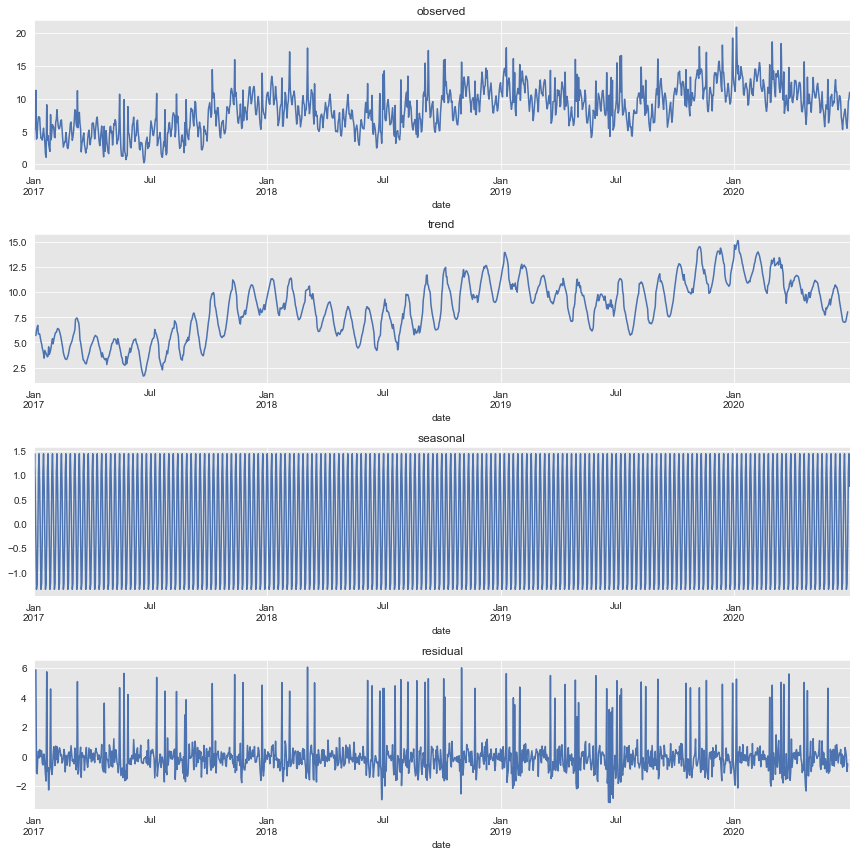

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_obj = seasonal_decompose(
    x=df_train[['date', 'y']].set_index('date'), 
    model='additive'
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
decomposition_obj.trend.plot(ax=ax[1])
ax[1].set(title='trend')
decomposition_obj.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
decomposition_obj.resid.plot(ax=ax[3])
ax[3].set(title='residual')
plt.tight_layout()

Note that the trend component also includes the monthly and yearly seasonality. This might not always be desired. You can of course use the smoothing technique presented above or keep decomposing the resulting trend by specifying the `period` parameter in the `seasonal_decompose` function.

- Correlation

In [27]:
# We remove the first and last 3 entries as they are np.nan coming from the moving average method. 
np.corrcoef(decomposition_obj.resid[3:-3], df_train['x'][3:-3])[0, 1]

0.8616875939727174

- Effect Estimation

In [28]:
x_df['decomposition_resid'] = decomposition_obj.resid.values

x_mod2 = smf.ols(formula='decomposition_resid ~ x', data=x_df[3:-3])

x_res2 = x_mod2.fit()

print(x_res2.summary())

                             OLS Regression Results                            
Dep. Variable:     decomposition_resid   R-squared:                       0.743
Model:                             OLS   Adj. R-squared:                  0.742
Method:                  Least Squares   F-statistic:                     3659.
Date:                 Tue, 11 Feb 2020   Prob (F-statistic):               0.00
Time:                         11:32:47   Log-Likelihood:                -1311.4
No. Observations:                 1271   AIC:                             2627.
Df Residuals:                     1269   BIC:                             2637.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2828      0.020    -14.40

We get similar results as above. 

**Remarks:**
- In real life applications the effects of external regressors might include lags. A correlation analysis with lags needs to be done before modeling. 
- Also, linear relations might serve as a good first approximation. Nevertheless, going into non-linear relations might improve the model significantly. Two concrete methods which appear often is to model via [adstock effect](https://en.wikipedia.org/wiki/Advertising_adstock) and [generalized additive models](https://en.wikipedia.org/wiki/Generalized_additive_model). 

## Define Model

Based on the previous analysis we have identified the main components of out time series:

- A `local_linear_trend` 

- Seasonality:

    - `month_of_year` 
    - `day_of_week` 
    - `day_of_month` 
    
- External regressor `x_var`.

We define each of these components separately in order to build out sts-model using TensorFlow Probability. 

In [29]:
# Local linear trend. 
local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=df_train['y'], 
    name='local_linear_trend',
)

# We need to pre-define the number of days in each month.
num_days_per_month = np.array(
  [
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
    [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31] # year with leap day.
  ] 
)  

# Define month of year seasonal variable.
month_of_year = tfp.sts.Seasonal(
  num_seasons=12,
  num_steps_per_season=num_days_per_month,
  name='month_of_year'
)

# Define day of week as seasonal variable.
day_of_week = tfp.sts.Seasonal(
    num_seasons=7, 
    num_steps_per_season=1,
    observed_time_series=df_train['y'], 
    name='day_of_week',
)

# Create cyclic variable for day of the month.
design_matrix_day_of_month = tf.reshape(
    np.sin(2*np.pi*df['day_of_month'] / df['daysinmonth']).values.astype(np.float32), 
    (-1, 1)
)

# Define day of the month as an external regressor.
# We do not encode it as seasonal as the number of steps is not uniform.
day_of_month = tfp.sts.LinearRegression(
    design_matrix=design_matrix_day_of_month,
    name='day_of_month'
)

# Define external regressor component. 
# We use the whole data set (df) as we expect to have these values in the future. 
design_matrix_x_var = tf.reshape(df['x'].values.astype(np.float32), (-1, 1))

x_var = tfp.sts.LinearRegression(
    design_matrix=design_matrix_x_var,
    name='x_var'
)

Instructions for updating:
Do not call `graph_parents`.


Now we build the model:

In [30]:
model_components = [
    local_linear_trend, 
    month_of_year, 
    day_of_week, 
    day_of_month, 
    x_var,
]

toy_model = tfp.sts.Sum(
    components=model_components, 
    observed_time_series=df_train['y']
)

Let us see the model parameters and their priors:

In [31]:
for p in toy_model.parameters:
    print('-'*140)
    print('Parameter: ' + p.name)
    print('Prior: ' + str(p.prior))
    

--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: observation_noise_scale
Prior: tfp.distributions.LogNormal("Sum_LogNormal", batch_shape=[], event_shape=[], dtype=float32)
--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: local_linear_trend/_level_scale
Prior: tfp.distributions.LogNormal("local_linear_trend_level_scale_prior", batch_shape=[], event_shape=[], dtype=float32)
--------------------------------------------------------------------------------------------------------------------------------------------
Parameter: local_linear_trend/_slope_scale
Prior: tfp.distributions.LogNormal("local_linear_trend_slope_scale_prior", batch_shape=[], event_shape=[], dtype=float32)
-----------------------------------------------------------------------------------------------------------------

## Model Fit

### Variational Inference (Short Intro)

We follow the strategy of the TensorFlow Probability [use cases](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083) and fit the model using variational inference. I find the article [Variational Inference: A Review for Statisticians](https://arxiv.org/pdf/1601.00670.pdf) very good for an introduction to the subject. The main idea of variational inference is to use otimization methods to minimize the [Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) divergence inorder to approximate a conditional density within a family of specified parameter densities $\mathfrak{D}$. Specifically, assume we are given observed variables $x$ (i.e. data) and let $z$ be a set of latent variables with joint density $p(x, z)$. We are interested in  computing the conditional density

$$
p(z|x) = \frac{p(x, z)}{p(x)}, \quad\text{where} \quad p(x)=\int p(x, z) dz. 
$$

This last integral (known as the *evidence*) is in general very hard to compute. The main idea of variational inference is to solve the optimization problem

$$
q^{*}(z)=\min_{q \in \mathfrak{D}} \text{KL}(q(z)||p(z|x)), 
$$

where 

$$
\begin{align}
\text{KL}(q(z)||p(z|x)) =& \text{E}[\log(q(z))] - \text{E}[\log(p(z|x))] \\
=& \text{E}[\log(q(z))] - \text{E}[\log(p(z,x))] - \text{E}[\log(p(x))] \\
=& \text{E}[\log(q(z))] - \text{E}[\log(p(z,x))] - \log(p(x)
\end{align}
$$

is the Kullback-Leibler (KL) divergence (the expected values are taked with respect to $q(z)$). Note that this quanity contains a term $\text{E}[\log(p(x))]$, which is hard to compute. *Because we cannot compute the KL, we optimize an alternative objective that is equivalent
to the KL up to an added constant*,

$$
\text{ELBO}(q) = \text{E}[p(z, x)] - \text{E}[\log(q(z))]
$$

ELBO stands for *evidence lower bound*. 

**Remark:** Note that

$$
\text{ELBO}(q)= -\text{KL}(q(z)||p(z|x)) + \log(p(x))
$$

Moreover, it is easy to see that 

$$
\text{ELBO}(q)= \text{E}[\log(p(x|z)]-\text{KL}(q(z)||p(x))
$$

The first term is the expected likelihood and the second term is the negative divergence between the variational density and the prior.

For more details and enlightening comments, please refer to the artivle mentioned above (from which this short introduction was taken from). 

### Variational Inference in TensorFlow Probability

First we build the variational surrogate posteriors, which consist of independent normal distributions with two trainable hyper-parameters `loc` and `scale` for each paramter in the model. That is, $\mathfrak{D}$ above consists of normal distributions.

In [32]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=toy_model, seed=42)

Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.


Let us sample from the prior distributions and plot the corresponding densities:

In [33]:
q_prior_samples = variational_posteriors.sample(1000)

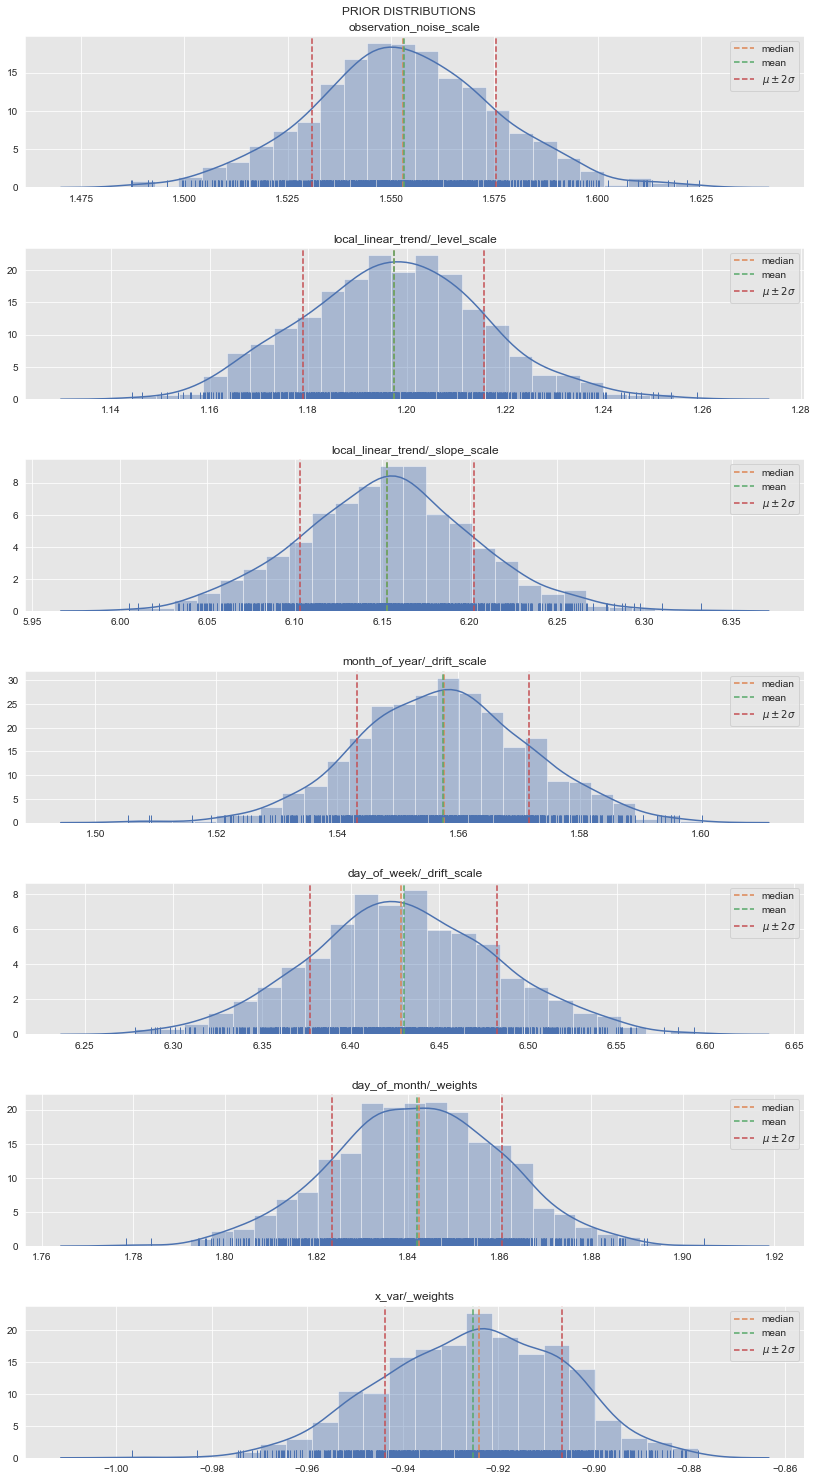

In [34]:
num_parameters = len(toy_model.parameters)

fig, ax = plt.subplots(num_parameters, 1, figsize=(12, 21))

for i, param in enumerate(toy_model.parameters):
    
    param_mean = np.mean(q_prior_samples[param.name], axis=0)
    param_median = np.median(q_prior_samples[param.name], axis=0)
    param_std = np.std(q_prior_samples[param.name], axis=0)
    
    sns.distplot(a=q_prior_samples[param.name], rug=True, ax=ax[i])
    ax[i].set(title=param.name)
    ax[i].axvline(x= param_median, color=sns_c[1], linestyle='--', label='median')
    ax[i].axvline(x= param_mean, color=sns_c[2], linestyle='--', label='mean')
    ax[i].axvline(x= param_mean + param_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
    ax[i].axvline(x= param_mean - param_std, color=sns_c[3], linestyle='--')
    ax[i].legend()
    
plt.tight_layout(pad=3.0)
plt.suptitle('PRIOR DISTRIBUTIONS', y=0.99);

Next we run the optimization procedure.

In [35]:
num_variational_steps = int(200)

# Set optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.1)

# Using fit_surrogate_posterior to build and optimize 
# the variational loss function.
@tf.function(experimental_compile=True)
def train():
    # Build the joint density. 
    target_log_prob_fn = toy_model.joint_log_prob(
        observed_time_series=df_train['y']
    )
    
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob_fn,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
        seed=42
    )
    
    return elbo_loss_curve

# Run optimization.
elbo_loss_curve = train()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Let us plot the `elbo_loss_curve`.

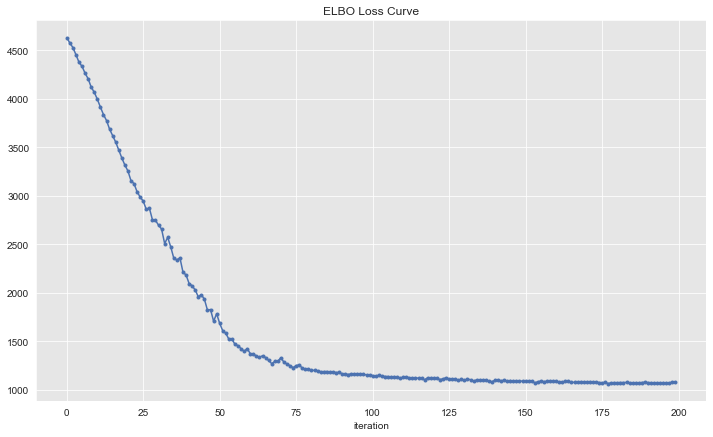

In [36]:
fig, ax = plt.subplots()
ax.plot(elbo_loss_curve, marker='.')
ax.set(title='ELBO Loss Curve', xlabel='iteration');

We see that a minimum has been reached. 

Now we sample from the variational posteriors obtained:

In [37]:
q_samples = variational_posteriors.sample(1000)

Let us plot the parameter posterior distributions:

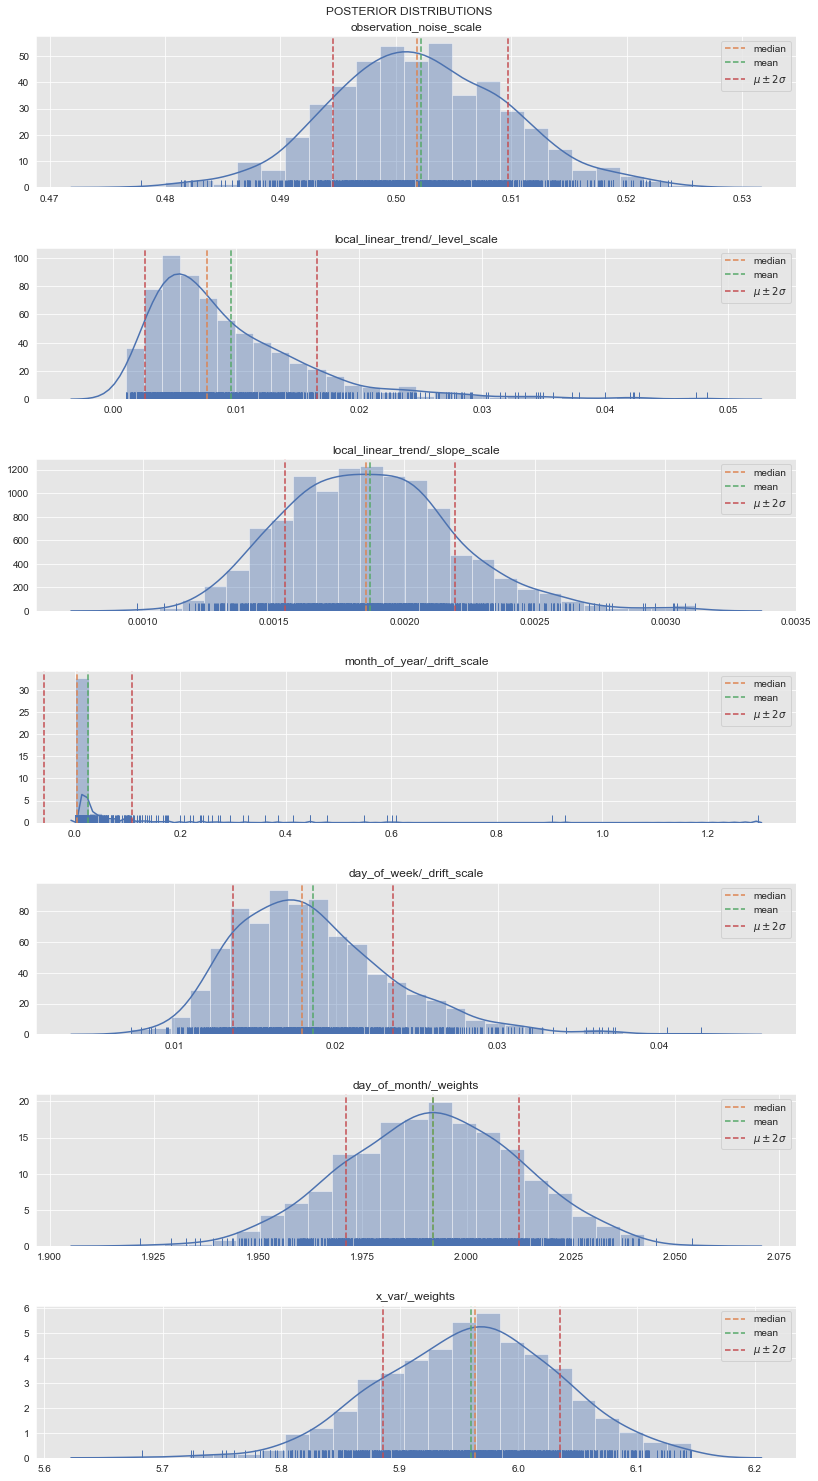

In [38]:
num_parameters = len(toy_model.parameters)

fig, ax = plt.subplots(num_parameters, 1, figsize=(12, 21))

for i, param in enumerate(toy_model.parameters):
    
    param_mean = np.mean(q_samples[param.name], axis=0)
    param_median = np.median(q_samples[param.name], axis=0)
    param_std = np.std(q_samples[param.name], axis=0)
    
    sns.distplot(a=q_samples[param.name], rug=True, ax=ax[i])
    ax[i].set(title=param.name)
    ax[i].axvline(x= param_median, color=sns_c[1], linestyle='--', label='median')
    ax[i].axvline(x= param_mean, color=sns_c[2], linestyle='--', label='mean')
    ax[i].axvline(x= param_mean + param_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
    ax[i].axvline(x= param_mean - param_std, color=sns_c[3], linestyle='--')
    ax[i].legend()
    
plt.tight_layout(pad=3.0)
plt.suptitle('POSTERIOR DISTRIBUTIONS', y=0.99);

In [39]:
# Get mean and std for each parameter.
print('Inferred parameters:')
for param in toy_model.parameters:
    print('{}: {} +- {}'.format(
        param.name,
        np.mean(q_samples[param.name], axis=0),
        np.std(q_samples[param.name], axis=0))
    )

Inferred parameters:
observation_noise_scale: 0.5021326541900635 +- 0.007594980299472809
local_linear_trend/_level_scale: 0.009583557024598122 +- 0.006971438881009817
local_linear_trend/_slope_scale: 0.0018680891953408718 +- 0.0003248010470997542
month_of_year/_drift_scale: 0.024883059784770012 +- 0.08357027918100357
day_of_week/_drift_scale: 0.018588630482554436 +- 0.004957796074450016
day_of_month/_weights: [1.9918456] +- [0.02078216]
x_var/_weights: [5.9605927] +- [0.07460035]


**Remark:** Observe that the estimated effect of the regressor `x` is around 5.96.

## Model Predictions

We now generate the forecast six months ahead. 

In [40]:
# Compute number of days in the last 6 months of 2020.
forecast_window = num_days_per_month[-1][6:13].sum()

# Get forecast distribution.
forecast_dist = tfp.sts.forecast(
    toy_model,
    observed_time_series=df_train['y'],
    parameter_samples=q_samples,
    num_steps_forecast=forecast_window 
)

In [41]:
# Sample and compute mean and std. 
num_samples = 100

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy().flatten(),
    forecast_dist.stddev().numpy().flatten(),
    forecast_dist.sample(num_samples).numpy().flatten()
)

Next, we store the predictions on the `df_test` data frame.

In [42]:
df_test['y_pred'] = forecast_mean
df_test['y_pred_std'] = forecast_scale
df_test['errors'] = df_test['y'] - df_test['y_pred']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Let us plot the predictions:

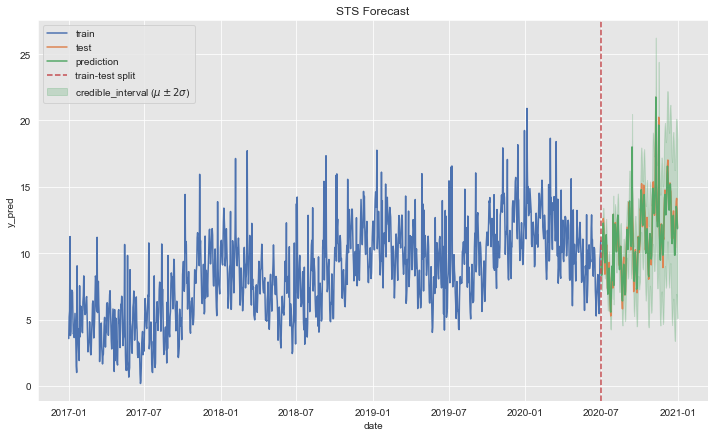

In [43]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test['date'],
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)

sns.lineplot(x='date', y='y', label='train', data=df_train, ax=ax)
sns.lineplot(x='date', y='y', label='test', data=df_test, ax=ax)
sns.lineplot(x='date', y='y_pred', label='prediction', data=df_test, ax=ax)
ax.axvline(x= threshold_date, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

Zooming in:

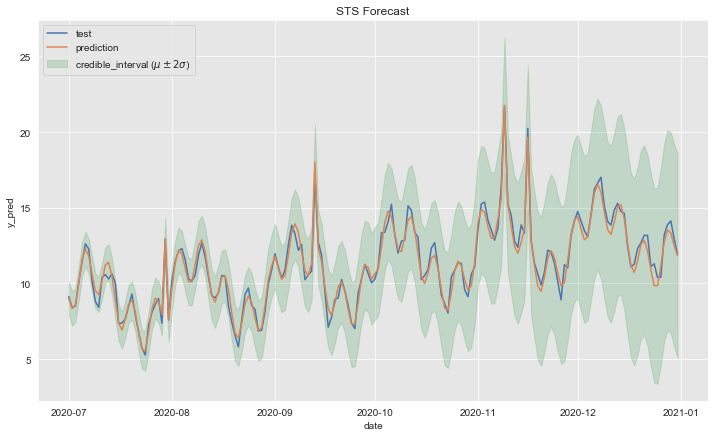

In [44]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test['date'],
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)
sns.lineplot(x='date', y='y', label='test', data=df_test, ax=ax)
sns.lineplot(x='date', y='y_pred', label='prediction', data=df_test, ax=ax)
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

Let us see it as a scatter plot.

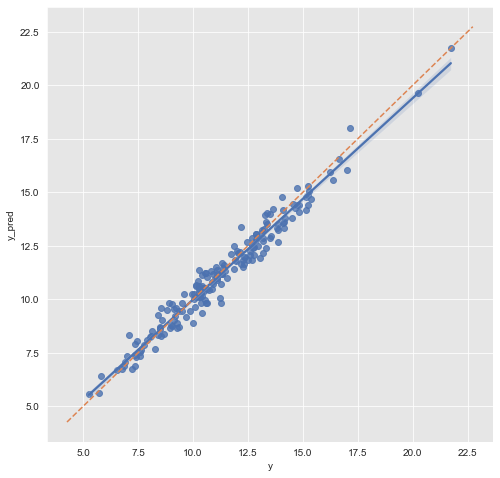

In [45]:
fig, ax = plt.subplots(figsize=(8,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_test['y'].min() - 1, stop=df_test['y'].max() + 1, num=100)

sns.regplot(x='y', y='y_pred', data=df_test, ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, ax=ax)
ax.lines[1].set_linestyle('--')

## Error Analysis

It is important to emphazise that, for any modeling problem, getting the predictions is not the end of the story. It is very important to analyze the errors to understand where is the model not working as expected. 

- Distribution

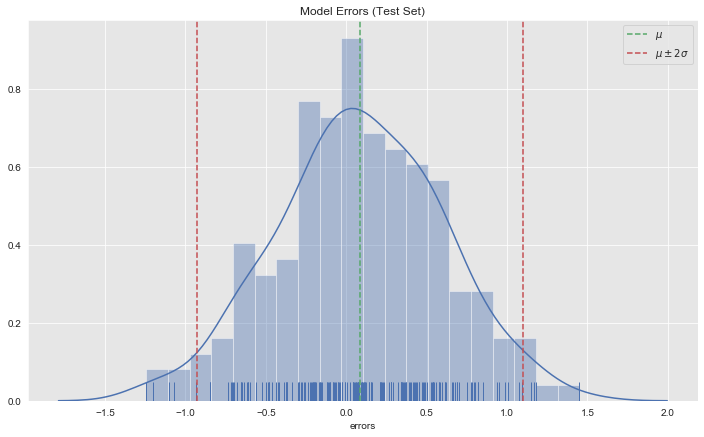

In [46]:
errors_mean = df_test['errors'].mean()
errors_std = df_test['errors'].std()

fig, ax = plt.subplots()

sns.distplot(a=df_test['errors'], ax=ax, bins=20, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

The errors look normally distributed and centered around zero. 

- Autocorrelation

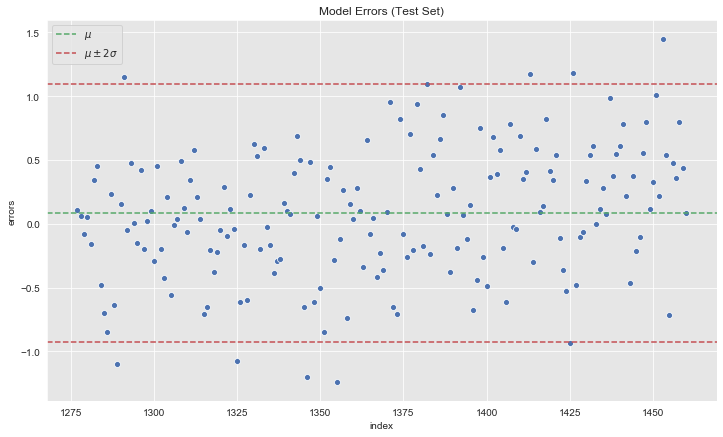

In [47]:
fig, ax = plt.subplots()

sns.scatterplot(x='index', y='errors', data=df_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

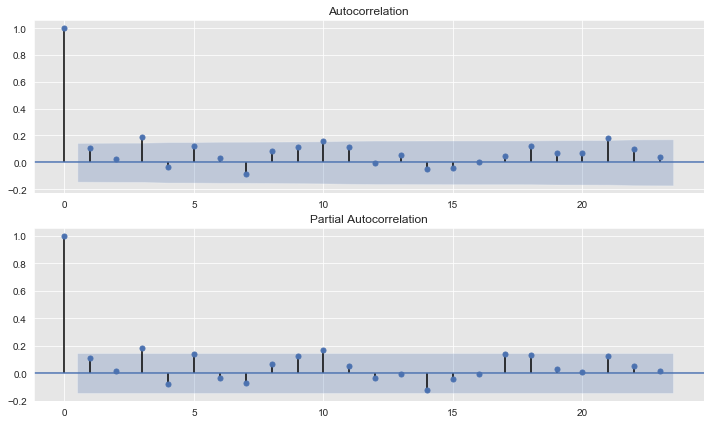

In [48]:
fig, ax = plt.subplots(2, 1)
plot_acf(x=df_test['errors'], ax=ax[0])
plot_pacf(x=df_test['errors'], ax=ax[1]);

We do not see any significant (partial) autocorrelation nor patterns on the errors. They look independent and normally distributed around zero. 

## Model Fit Decomposition

Finally, let us see the individual model components.

In [49]:
component_dists = tfp.sts.decompose_by_component(
    model=toy_model,
    observed_time_series=df_train['y'],
    parameter_samples=q_samples
)

In [50]:
component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

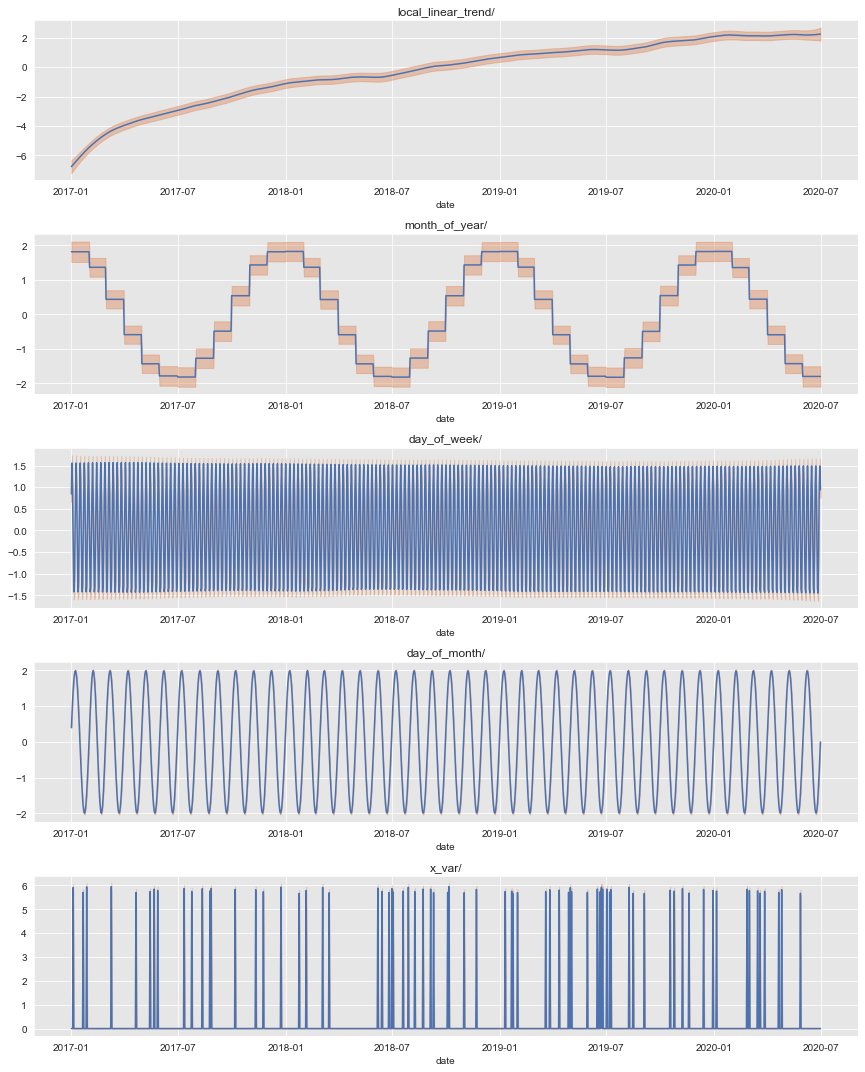

In [51]:
num_components = len(component_means)

fig, ax = plt.subplots(num_components, 1, figsize= (12, 15))

for i, component_name in enumerate(component_means.keys()):
    component_mean = component_means[component_name]
    component_stddev = component_stddevs[component_name]
    
    sns.lineplot(x=df_train['date'], y=component_mean, color=sns_c[0], ax=ax[i])
    
    ax[i].fill_between(
        x=df_train['date'],
        y1=component_mean-2*component_stddev,
        y2=component_mean+2*component_stddev,
        alpha=0.4, 
        color=sns_c[1]
    )
    
    ax[i].set(title=component_name)

plt.tight_layout()

---
This was a first exploration of the [STS TensorFlow Probability](https://www.tensorflow.org/probability/api_docs/python/tfp/sts) module. We emphasized on the time series exploratory analysis since, in real applications, we are never given the time series structure prior modeling (that would be quite boring). I really want to keep exploring the tools and techniques implemented in the this probabilistic programing framework. 